In [1]:
# the tensorflow version of the inverted pendulum with a neural net controller

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tf_funs import * #EKF, and helper in tensorflow
import sys

tf.set_random_seed(101)
pi = math.pi
np.random.seed(101)

sess = tf.Session()


In [2]:
def ip_dynamics(X,C,g,L,dt):
    #function for inverted pendulum dynamics
    return dt*np.array([X[1]+C[0],g/L*math.sin(X[0])+C[1]])
def ip_dynamics_tf(X,C,g,L,dt):
    #function for inverted pendulum dynamics, using tensorflow
    return tf.stack([dt*(X[1]+C[0]),dt*(g/L*tf.sin(X[0])+C[1])])

In [3]:
#build graphs
xdim = 2 #state dimension
udim = 2 #control dimension

X_est = tf.placeholder(shape=(xdim),dtype=tf.float32,name='X_est') #the state estimate
PI_est = tf.placeholder(shape = (xdim,xdim),dtype=tf.float32, name = 'PI_est') #estimated covariance
Y_tp1 = tf.placeholder(shape=(xdim),dtype=tf.float32, name = 'Y_tp1') #the most recent observation
#Q  = tf.placeholder(dtype=tf.float32)
#R = tf.placeholder(dtype=tf.float32)
Control = tf.placeholder(shape = udim, dtype=tf.float32, name='Control')

#params for experiment
#wong dynamics
T = 2000 #number of steps

#define the noise for the system
dt = 1.0e-3
sigsstate = (1./dt)*9e-9 #not sure how strong this should be yet
sigsobs = 1.0e-6 #good around 0.5
Q = sigsstate*np.eye(xdim)
Q_tf = tf.constant(Q,dtype=tf.float32, name = 'Q') #state noise covariance
R = sigsobs*np.eye(xdim)
R_tf = tf.constant(R,dtype=tf.float32, name = 'R') #observation noise covariance  
gamma = 1.0e-8

#graphs for updating state and observation
g = 9.8
gtarg = -9.8
L = 0.1
true_model_est = ip_dynamics_tf(X_est,Control,g,L,dt)#state est. gradient, full myopic
true_model_est_null = ip_dynamics_tf(X_est,[0.,0.],g,L,dt)#state est. gradient w/o control
target_model_est = ip_dynamics_tf(X_est,[0.,0.],gtarg,L,dt) #state est. target model

#the non-tensorflow anonymous functions, for generalizations
true_nontf = lambda x,c: ip_dynamics(x,c,g,L,dt)
target_nontf = lambda x: ip_dynamics(x,[0.,0.],gtarg,L,dt)

X_plus,PI_plus = EKF(X_est,Y_tp1,PI_est,true_model_est,true_model_est_null,Q_tf,R_tf,xdim,dt)

#myopic controller
Cnew = myopicController_meanonly(
    X_est,PI_est,Control,gamma,true_model_est,
    true_model_est_null,target_model_est,xdim,udim)

#covariance prediction update graph
Ak = dynamics_linearized(X_est,true_model_est_null,xdim)

#loss function
loss_tf = loss_full(X_est,PI_est,true_model_est,target_model_est)


In [21]:
#build the neural net controller parts
tf.reset_default_graph() #helps with the get_variable usage by clearing the variables
mb_size = T #size of the minibatch, a single simulation
Z_dim = 100

#will be the state estimate input to controller
X = tf.placeholder(tf.float32, shape=(mb_size, xdim), name='X')
#covariance estimate input to controller. don't use yet
PI = tf.placeholder(tf.float32, shape=(mb_size, xdim,xdim), name='PI')
Input = [X,PI]

#two-layer RLU. 1 is bottom layer, 2 is top layer
#current architecture: first layer does rotation of state estimate, 
#second layer maps to control space

#C_W1 = tf.Variable(xavier_init([xdim, xdim]), name='C_W1')
C_W1 = tf.get_variable('C_W1',shape=[xdim, xdim],
           initializer=tf.contrib.layers.xavier_initializer())
C_b1 = tf.Variable(tf.zeros(shape=[xdim]), name='C_b1')

#C_W2 = tf.Variable(xavier_init([xdim, udim]), name='C_W2')
C_W2 = tf.get_variable('C_W2',shape=[xdim,udim],
                       initializer=tf.contrib.layers.xavier_initializer())
C_b2 = tf.Variable(tf.zeros(shape=[udim]), name='C_b2')

theta_C = [C_W1, C_W2, C_b1, C_b2]

def controller(x):
    C_h1 = tf.nn.relu(tf.matmul(x, C_W1) + C_b1)
    C_log_prob = tf.matmul(C_h1, C_W2) + C_b2
    C_prob = tf.nn.sigmoid(C_log_prob)

    return C_prob
Controller_test = controller(X)

In [6]:
#generate training data
ns = 1
ctest = np.random.normal(0,1,[xdim,T,ns]) #random control signal

tf.set_random_seed(101)
pi = math.pi
np.random.seed(101)
statenoise = np.random.normal(0,sigsstate**0.5,[xdim,T,ns])
obsnoise = np.random.normal(0,sigsobs**0.5,[xdim,T,ns])
G = dt**(0.5)*np.eye(xdim) #system noise matrix, for covariance prediction

x_estvec = np.zeros((xdim,T,ns))
xvec = np.zeros((xdim,T,ns))
yvec = np.zeros((xdim,T,ns))
x_targvec = np.zeros((xdim,T,ns))
PI_estvec = np.zeros((xdim,xdim,T,ns))
contall = np.zeros((udim,T,ns))

loss = np.zeros((T,ns))

lag = 0 #how many steps in the past will we receive observations

#init = tf.global_variables_initializer()
#sess.run(init)

#failure happened at iteration 76
x_init = np.array([ 0.1,  0.0])

for m in range(ns):
    #x_init = np.random.uniform(0.,1.,(2,))
    PI_init = [[0.,0.],[0.,0.]] #initial covariance
    c_init = [0.,0.]

    xest_k = x_init
    pi_k = PI_init
    c_k = c_init
    x_k = x_init
    x_targ_k = x_init
    ykp1 = np.array(x_init)

    x_estvec[:,0,m] = x_init
    xvec[:,0,m] = x_init
    x_targvec[:,0,m] = x_init
    PI_estvec[:,:,0,m] = PI_init

    print(m)
    
    #go ahead and propagate lag-steps ahead before starting state estimation and such
    for k in range(1,lag):     
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],c_init)
        grad_targ = target_nontf(x_targvec[:,k-1,m])

        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]

        #set estimates in beginning lags to initial state
        x_estvec[:,k,m] = x_init
        PI_estvec[:,:,k,m] = PI_init

    for k in range(max(1,lag),T): 
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],contall[:,k-1,m])
        grad_targ = target_nontf(x_targvec[:,k-1,m])
        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]

        test = sess.run([X_plus,PI_plus],
                        {X_est:x_estvec[:,k-lag-1,m], PI_est:PI_estvec[:,:,k-lag-1,m],
                         Control:contall[:,k-lag-1,m], Y_tp1:yvec[:,k-lag,m]})
        x_estvec[:,k-lag,m] = test[0]
        PI_estvec[:,:,k-lag,m] = test[1]
        
        #predit lag states in the future to calculate control
        x_est_n = x_estvec[:,k-lag,m]
        PI_est_n = PI_estvec[:,:,k-lag,m]
        
        for n in range(lag):
            #state prediction step
            grad_cont = true_nontf(x_est_n,contall[:,k-lag-1+n,m])

            #covariance prediction step. calculate jacobian
            Ak_n= sess.run(Ak,
                        {X_est: x_est_n, PI_est: PI_est_n,
                         Control: contall[:,0,m], Y_tp1:yvec[:,0,m]})

            x_est_n = x_est_n + grad_cont
            PI_est_n = np.matmul(Ak_n,PI_est_n) + np.matmul(PI_est_n,np.transpose(Ak_n)) + np.matmul(
                np.matmul(G,Q),np.transpose(G))

        #run myopic controller using predicted state estimated. cov, doesnt matter
        #find control for time k
        #c_k = sess.run(Cnew,{X_est:x_est_n, PI_est:PI_est_n,
        #                     Control:contall[:,k-1,m], Y_tp1:yvec[:,k,m]})
        #contall[:,k,m] = c_k
        contall[:,k,m] = ctest[:,k,m] #the random control
        
        #the mean expected loss
        #loss[k-lag,m] = np.linalg.norm(true_nontf(x_estvec[:,k-lag,m],contall[:,k-lag,m])-
        #                              target_nontf(x_estvec[:,k-lag,m]))**2
        
        #the expected loss to second order
        ltest = sess.run(loss_tf,{X_est:x_estvec[:,k-lag,m],
                                               PI_est:PI_estvec[:,:,k-lag,m],
                                               Control:contall[:,k-lag,m]
                                              })
        loss[k-lag,m] = ltest[0]
        
        
        #loss_nocont[k-lag,m] = np.linalg.norm(
        #    true_nontf(x_estvec[:,k-lag,m],[0.,0.])-
        #    target_nontf(x_estvec[:,k-lag,m]))**2
        
    #set final lag estimate values to esimate
    for k in range(lag):
        x_targvec[:,T-lag+k,m] = x_targvec[:,T-lag-1,m]
        x_estvec[:,T-lag+k,m] = x_estvec[:,T-lag-1,m]
        PI_estvec[:,:,T-lag+k,m] = PI_estvec[:,:,T-lag-1,m]
        
#define the training inputs and loss
x_train = x_estvec[:,:,0]


0


In [32]:
#try running the controller to generate a random signal
#print(np.transpose(x_train).shape)
crun = sess.run(X,{X:np.transpose(x_train)})
#print(sess.run(X_est,{X_est:np.array([2.,3.])}))

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("X:0", shape=(2000, 2), dtype=float32) is not an element of this graph.

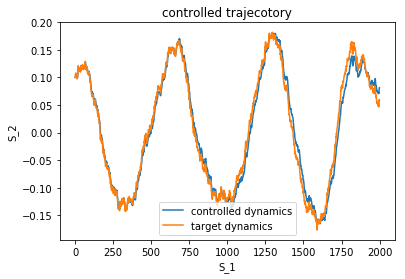

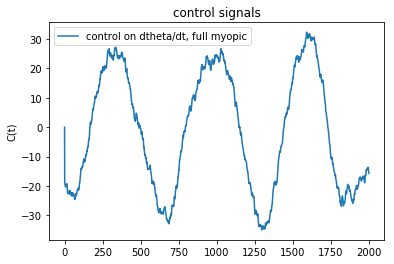

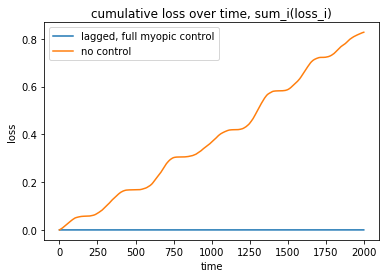

In [12]:
#true state
tind = 0
plt.plot(x_estvec[0,:,tind],label='controlled dynamics')
plt.plot(x_targvec[0,:,tind],label = 'target dynamics')
plt.legend()
plt.xlabel('S_1')
plt.ylabel('S_2')
plt.title('controlled trajecotory')
plt.show()


#plt.plot(test[2][:,0]+ (test[3][:,0,0])**0.5)
#plt.plot(test[2][:,0]- (test[3][:,0,0])**0.5)
#plt.show()
plt.plot(contall[1,:,tind],label='control on dtheta/dt, full myopic')
plt.ylabel('C(t)')
plt.title('control signals')
plt.legend()
plt.show()

#expected state
fullloss = plt.plot(np.cumsum(loss[:,tind]),label='lagged, full myopic control')
nocontloss = plt.plot(np.cumsum(loss_nocont[:,tind]),label='no control')

#fullloss = plt.plot(np.cumsum(loss_both[:,tind]),label='full myopic control')
#nocontloss = plt.plot(np.cumsum(loss_meanonly[:,tind]),label='mean-only')
#fullloss_test = plt.plot(np.cumsum(loss_test_both[0,:,tind]),label='full')
#nocontloss_test = plt.plot(np.cumsum(loss_test_both[3,:,tind]),label='full first term ')



#nocontloss_test = plt.plot(loss_test_meanonly[:,tind]-loss_test_both[:,tind],
#                           label='test difference mean-only - both')


plt.xlabel('time')
plt.ylabel('loss')
plt.title('cumulative loss over time, sum_i(loss_i)')
plt.legend()
plt.show()
#standard deviation





In [65]:
fp = grad_elemwise(true_model_est,X_est)
gp = grad_elemwise(target_model_est,X_est)
test = tf.matmul(tf.transpose(fp-gp),fp-gp)
testfull = tf.trace(tf.matmul(test,PI_est))
testrun = sess.run(test,
                        {X_est:x_estvec[:,20,0], PI_est:PI_estvec[:,:,20,0],
                         Control:contall[:,19,0], Y_tp1:yvec[:,20,0]})

In [66]:
testrun

array([[ 0.03816825,  0.        ],
       [ 0.        ,  0.        ]], dtype=float32)